# Data Filtering and Binning

This notebook lets you filter and bin tabular data from ISS and INO images.

For best results, run cells from the top down.

In [1]:
# Run this cell to import required python packages 
# no additions are needed here. You may skip to the next cell after running this one.
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from ROI_functions_images.fluorescence_functions import data_binning, filter_df
import json

# File Loading

Load and view tabular data from CSV file.

In [2]:
#Run this cell to load csv file: 
file = r'file_path'     #replace file_path with full path to csv file surrounded by quotation marks.
df = pd.read_csv(file)

In [3]:
# Run this cell to get a description of the csv file's data
df.describe()

,Unnamed: 0,Slice_ID,ROI_ID,ROI_size,Donor_T0_intensity,Acceptor_T0_intensity,Donor_intensity,Acceptor_intensity,Donor_lifetime,Phasor_G,Phasor_S,FRET_efficiency
count,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,1.406800e+04,14068.000000,14068.000000,14068.000000
mean,7033.500000,37.904180,101.299545,48.948891,449160.734622,81562.601436,529.854492,56.680056,3.679021e-09,0.837557,0.386194,3.183655
std,4061.226128,23.564581,65.037201,28.981576,140620.080465,69837.026924,218.085508,147.382393,1.911142e-10,0.012158,0.015013,5.029322
min,0.000000,0.000000,1.000000,1.000000,3650.333333,521.000000,21.000000,0.000000,1.885912e-09,0.701402,0.223886,-53.670639
25%,3516.750000,17.000000,46.000000,30.000000,359474.666667,20408.000000,368.750479,2.788316,3.678901e-09,0.832255,0.386495,0.983660
50%,7033.500000,36.000000,95.000000,46.000000,477325.333333,61003.333333,517.781250,5.600000,3.724572e-09,0.834803,0.389988,1.984942
75%,10550.250000,59.000000,151.000000,64.000000,522305.333333,117200.666667,670.191219,13.153880,3.762621e-09,0.837805,0.392800,3.186807
max,14067.000000,79.000000,303.000000,230.000000,697898.666667,263729.666667,1499.953125,1133.633333,5.839484e-09,0.951423,0.514351,50.370743


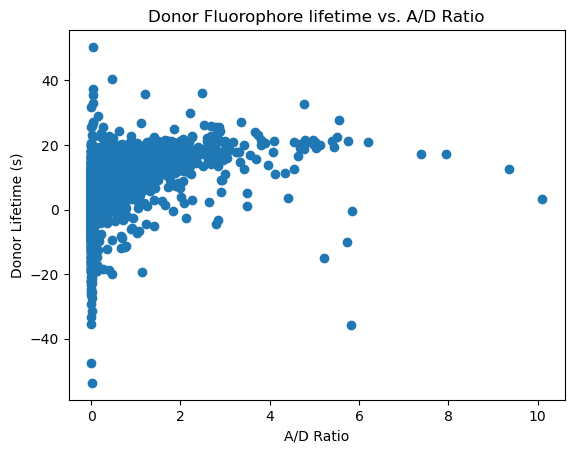

In [4]:
# Run this cell to plot raw data

# change the entries below to df["title of desired column"] to change plot values
x_data = df["Acceptor_intensity"] / df["Donor_intensity"]
y_data = df["FRET_efficiency"]

# change the entries below to edit plot labels/title
title = 'Donor Fluorophore lifetime vs. A/D Ratio'
x_label = 'A/D Ratio'
y_label = 'Donor Lifetime (s)'


plt.figure()
plt.plot(x_data, y_data, 'o')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)
plt.show()

# Data Filtering
Raw data usually needs to be filtered before it can be used productively. 

Filter parameters to consider may include: 
- ROI size
- donor lifetime
- mean donor intensity
- acceptor to donor ratio
- FRET efficiency
- etc

Filter operations exclusively include:
- \> (use "gt")
- \< (use "lt")
- \>= (use "ge")
- \<= (use "le")
- == (use "ee")

N.B. The filtered dataframe is called subdf as opposed to df.

In [5]:
# Run this cell to save filter parameters 
# replace None below with the desired filter parameter
#   ex: to select only ROIs with more than 10 pixels -> replace None after 'ROI_size' with "gt10" 
#   N.B. filter parameters must be surrounded by either single or double quotation marks and all 
#        operators must be written using provided abbreviations.

ISS_filter_params = {
    'ROI_size':None,
    'Donor_T0_intensity':None,
    'Acceptor_T0_intensity':None,
    'Donor_intensity':None,
    'Acceptor_intensity':None,
    'Acceptor/Donor_ratio':None,
    'Donor_lifetime':None,
    'Phasor_G':None,
    'Phasor_S':None,
    'FRET_efficiency':None
}

INO_filter_params = {
    'Well_ID':None,    #Well_ID only supports == ("ee") operations
    'ROI_size':None,
    'T0_intensity':None,
    'Donor_intensity':None,
    'Spectral_Range0_intensity':None,    
    'Spectral_Range1_intensity':None,
    'Spectral_Range2_intensity':None,
    'Spectral_Range3_intensity':None,
    'Acceptor/Donor_ratio':None,
    'Donor_lifetime':None,
    'Phasor_G':None,
    'Phasor_S':None,
    'FRET_efficiency':None
}

In [6]:
# Run this cell to apply saved filter parameters above to the dataframe.

#change **ISS_filter_parameters to **INO_filter_parameters if working with data from an INO image.
subdf = filter_df(df, **ISS_filter_params)  

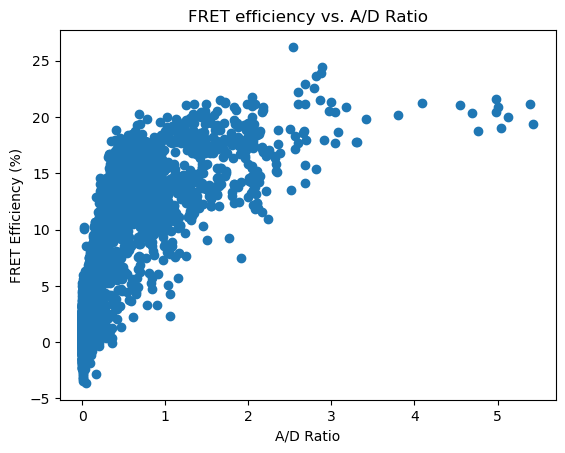

In [7]:
# Run this cell to plot filtered data

# change the entries below to subdf["title of desired column"] to change plot data
x_data = subdf["Acceptor_intensity"] / subdf["Donor_intensity"]
y_data = subdf["FRET_efficiency"]

# change the entries below to edit plot labels/title
title = 'FRET efficiency vs. A/D Ratio'
xlabel = 'A/D Ratio'
ylabel = 'FRET Efficiency (%)'

plt.figure()
plt.plot(x_data, y_data, 'o')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.show()

# Binning

Bin the filtered data and calculate mean, median, standard deviation, and standard error.

Bins can be automatically or manually generated.

In [13]:
# Run this cell to save custom bin edges

# Fill the list below with desired bin edges
#    :ex x_axis_bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]  will produce 5 bins of width 1, centered at 0, 1, 2, 3, 4

x_axis_bins = [ ]

In [14]:
# Run this cell to bin selected data

# Change the entries below to set what gets binned.
x_data = subdf["Acceptor_intensity"] / subdf["Donor_intensity"]
y_data = subdf["FRET_efficiency"]
auto_bins = True                      # if True: bins will be set automatically.
custom_bins = x_axis_bins             # auto_bins must be set to False to use custom bins

#change the value of csv_name to save binned data to the desired location
csv_name = r'ROI_binned_data.csv'


bin_size, y_means, y_medians, y_std_devs, y_std_errs, x_bin_centers, x_means = data_binning(x_data, y_data, auto_bins=auto_bins, bin_edges=custom_bins)

bindf = pd.DataFrame({
    'bin_size':bin_size,
    'y_means':y_means,
    'y_medians':y_medians,
    'y_std_devs':y_std_devs,
    'y_std_errs':y_std_errs,
    'x_bin_centers':x_bin_centers,
    'x_means':x_means
})
bindf.to_csv(csv_name)
bindf

,bin_size,y_means,y_medians,y_std_devs,y_std_errs,x_bin_centers,x_means
0,9985,1.699393,1.736991,1.231889,0.012328,0.000000,0.011340
1,484,5.667182,5.332335,3.645869,0.165721,0.162871,0.154137
2,309,10.801431,11.712013,4.101352,0.233318,0.325741,0.326109
3,191,12.504155,12.985818,3.662742,0.265027,0.488612,0.485104
4,207,14.133953,15.071315,3.485784,0.242279,0.651483,0.650020
5,180,13.411975,13.459849,2.810804,0.209505,0.814354,0.809118
6,92,13.231918,13.152470,3.594022,0.374703,0.977224,0.970478
7,66,14.323583,14.070625,3.396822,0.418120,1.140095,1.133740
8,58,15.288643,14.799327,3.163945,0.415446,1.302966,1.294570
9,163,15.892195,15.784520,2.901813,0.227288,1.465836,1.429654


# Curve Fitting

Curve fitting can be applied to binned data.

The default curve to be fitted is:

$$E\% =\frac{[Emax * (I_{acceptor}/I_{donor})^h}{Kd^h + (I_{acceptor}/I_{donor})^h} $$

since $I_{acceptor}/I_{donor}$ is just the acceptor to donor ratio, the equation is:

$$E\% =\frac{[Emax * (A:D)^h}{Kd^h + (A:D)^h} $$

In [15]:
# Run this cell to calculate curve parameters

#this line removes bins with only 1 or fewer values
bindf = bindf[bindf['bin_size'] > 1]

# Change the entries below to set data for curve fit
x_vals = bindf['x_means']
y_vals = bindf['y_means']
y_errs = bindf['y_std_devs']


def model_function(ratio, Emax, Kd, h):
    return (Emax * ratio**h)/(Kd**h + ratio**h)

popt, pcov = opt.curve_fit(model_function, x_vals, y_vals, sigma=y_errs, maxfev=200000)

print('Emax:', popt[0])
print('Kd:', popt[1])
print('h:', popt[2])

Emax: 27.230319744269018
Kd: 0.7916623810280953
h: 0.6536687511444004


<ipython-input-15-6213cf92a4cd>:13: RuntimeWarning: invalid value encountered in double_scalars
  return (Emax * ratio**h)/(Kd**h + ratio**h)


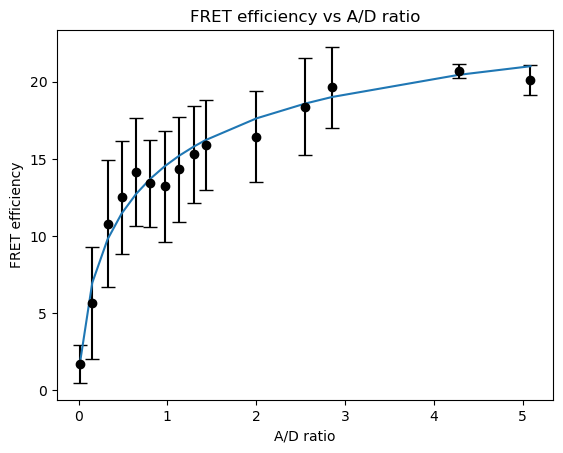

In [16]:
# Run this cell to plot bins and curve fit

# Change entries below below to change plot data
x_vals = bindf['x_means']
y_vals = bindf['y_means']
y_errs = bindf['y_std_devs']

# Change the entries below to edit plot labels/titles
x_label = 'A/D ratio'
y_label = 'FRET efficiency'
title = 'FRET efficiency vs A/D ratio'


plt.figure()
plt.errorbar(x_vals, y_vals, yerr=y_errs, fmt='ko', capsize=5, capthick=1)
plt.plot(x_vals, model_function(x_vals, popt[0], popt[1], popt[2]))
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)
plt.show()

# Save Configuration

Save the current filtering and binning parameters into a json file to batch process other csv files.

In [17]:
# Run this cell to save parameters as .json file

# Change ISS_filter_params for INO_filter_params if working with INO files
filter_bin_params = ISS_filter_params

# The parameters below will use the values saved above for automatic or custom binning.
filter_bin_params['auto_bins'] = auto_bins
filter_bin_params['x_axis_bins'] = x_axis_bins

# Change the text in quotation marks to set a custom name for your json file.
#    N.B. the file name must end with .json
file_name = 'filter_and_bin_params.json'


with open(file_name, 'w') as newfile:
    json.dump(filter_bin_params, newfile, indent=4)